# Exoplanet Classifier
Welcome to my forked version of The Exoplanet Classifier. This project was developed with my teammates from Ontohin 4b for the NASA Space Apps Challenge 2025.

I have used this notebook as a sandbox to test out different approaches to see how we can yield the maximum predictive performance. You will also find some interesting plots too.

## Importing the libraries

In [55]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV,learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report

from sklearn.ensemble import RandomForestClassifier,VotingClassifier,StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek

from matplotlib import pyplot as plt
import seaborn as sns

import time
import pandas as pd
import numpy as np
import joblib

## Importing and cleaning Data

In [26]:
# Loading and processing 1st Dataset (NASA Kepler Objects of Interest)
df_raw = pd.read_csv("data/kepler_data.csv", comment="#")

feature_list = ["koi_disposition","koi_period","koi_time0bk",
 "koi_depth","koi_prad","koi_sma","koi_incl","koi_teq","koi_insol",
 "koi_impact","koi_ror","koi_srho","koi_dor","koi_num_transits"
]

df_selected = df_raw[feature_list]

df_1 = df_selected.copy()

# Loading and processing 2nd dataset (NASA K2 Objects of Interest)
df_2 = pd.read_csv("data/k2_data.csv",comment="#")

Feature Engineering to construct number of transits in K2 Dataset

In [27]:
## Feature Engineering missing column in K2 (koi_num_transits) 

# Campaign dates dictionary (BJD)
campaign_dates = {
    0: (2456725.0, 2456805.0),
    1: (2456808.0, 2456891.0),

    3: (2456976.0, 2457064.0),
    4: (2457065.0, 2457159.0),
    5: (2457159.0, 2457246.0),
    6: (2457250.0, 2457338.0),
    7: (2457339.0, 2457420.0),
    8: (2457421.0, 2457530.0),
    9: (2457504.0, 2457579.0),
    10: (2457577.0, 2457653.0),
    11: (2457657.0, 2457732.0),
    12: (2457731.0, 2457819.0),
    13: (2457820.0, 2457900.0),
    14: (2457898.0, 2457942.0),
    15: (2457941.0, 2458022.0),
    16: (2458020.0, 2458074.0),
    17: (2458074.0, 2458176.0),
    18: (2458151.0, 2458201.0),
    19: (2458232.0, 2458348.0)
}

def get_window(camps):
    if pd.isna(camps) or not camps:
        return np.nan, np.nan
    
    camps = str(camps).split(',') if isinstance(camps, str) else camps
    
    # Filter valid campaign numbers and get start/end times
    starts = []
    ends = []
    for c in camps:
        try:
            camp_num = int(c.strip())
            if camp_num in campaign_dates:
                start, end = campaign_dates[camp_num]
                starts.append(start)
                ends.append(end)
        except (ValueError, KeyError):
            continue  
    
    return (min(starts) if starts else np.nan, max(ends) if ends else np.nan)

In [28]:
df_2['campaigns'] = df_2['k2_campaigns']
df_2[['obs_start_bjd', 'obs_end_bjd']] = df_2['campaigns'].apply(lambda x: pd.Series(get_window(x)))

# For transit counting (as before)
df_2['n_min'] = np.ceil((df_2['obs_start_bjd'] - df_2['pl_tranmid']) / df_2['pl_orbper'])
df_2['n_max'] = np.floor((df_2['obs_end_bjd'] - df_2['pl_tranmid']) / df_2['pl_orbper'])
df_2['num_transits'] = (df_2['n_max'] - df_2['n_min'] + 1).clip(lower=0)
df_2 = df_2[["disposition","pl_orbper","pl_tranmid","pl_trandep",
"pl_rade","pl_orbsmax","pl_orbincl","pl_eqt","pl_insol","pl_imppar","pl_ratror","pl_dens",
"pl_ratdor","num_transits"]]

Concatenating df_1 and df_2

In [ ]:
mapping = {"disposition":"koi_disposition","pl_orbper":"koi_period","pl_tranmid":"koi_time0bk",
           "pl_trandep":"koi_depth","pl_rade":"koi_prad","pl_orbsmax":"koi_sma",
           "pl_orbincl":"koi_incl","pl_eqt":"koi_teq","pl_insol":"koi_insol","pl_imppar":"koi_impact",
           "pl_ratror":"koi_ror","pl_dens":"koi_srho","pl_ratdor":"koi_dor","num_transits":"koi_num_transits"
           }
df_2 = df_2.rename(columns=mapping)

df = pd.concat([df_1,df_2])
print(df.shape)               # Output: (13568, 14)

(13568, 14)


In [30]:
# Input-output separation
X = df.iloc[:,1:].to_numpy()
y = df["koi_disposition"].map({"FALSE POSITIVE":0,"CANDIDATE":1,"CONFIRMED":2,"REFUTED":0}).to_numpy()

## ML Tasks

Train-test split

In [31]:
# Train-test split
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=1/3, shuffle=True, random_state=91, stratify=y
)

### **Trial - 01**: Trying out with different learners
In this part, I have performed a **GridSearchCV** on multiple classifier algorithms (**RandomForest** and **XGBoost**) to find the best hyperparameter configuration.

In [33]:
# Define Models
rf_model_1 = RandomForestClassifier(random_state=93)
xgb_model_1 = XGBClassifier(random_state = 94)

# Dimensionality Reduction
pca_1 = PCA(random_state=81)
lda_1 = LDA(n_components=2)

In [34]:
pipe_1 = Pipeline([
  ("impute",SimpleImputer(strategy="median")),
  ("scale",StandardScaler()),
  ("smote",SMOTE(random_state=11)),
  ("dimen",pca_1),
  ("model",xgb_model_1)
])

In [35]:
param_grid = [
  { # XGBClassifier, PCA On
    "model":[xgb_model_1],"model__n_estimators":[500,1000],
    "model__max_depth": [10,16,None],"model__learning_rate": [0.05,0.1],
    "dimen": [pca_1], "dimen__n_components": [0.90,0.95]
  },
  { # XGBClassifier, PCA On, SMOTE Off
    "model":[xgb_model_1],"model__n_estimators":[500,1000],
    "model__max_depth": [10,16,None],"model__learning_rate": [0.05,0.1],
    "dimen": [lda_1], "smote":["passthrough"]
  },
  { # RandomForestClassifier, PCA On
    "model": [rf_model_1],"model__n_estimators":[500,1000], 
    "model__max_depth": [10,16,None], "dimen": [pca_1], 
    "dimen__n_components": [0.90,0.95]
  },
  { # RandomForestClassifier, LDA On
    "model": [rf_model_1], "model__n_estimators": [500,1000], 
    "model__max_depth": [10,16,None], "dimen": [lda_1]
  }
]

In [36]:
rscv_1 = GridSearchCV(
  estimator=pipe_1,param_grid=param_grid,refit=True,cv=4,verbose=1,n_jobs=-1,
)

rscv_1.fit(x_train,y_train)

config_1 = rscv_1.best_params_
score_1 = rscv_1.best_score_
estimator = rscv_1.best_estimator_
print(f"Best Score = {score_1}")
print(f"Best Configuration = {config_1}")

Best Score = 0.6719750304142318
Best Configuration = {'dimen': PCA(random_state=81), 'dimen__n_components': 0.95, 'model': RandomForestClassifier(random_state=93), 'model__max_depth': 16, 'model__n_estimators': 500}


In [38]:
y_ture = y_test 
y_pred = rscv_1.predict(x_test)
print(classification_report(y_ture,y_pred))

              precision    recall  f1-score   support

           0       0.80      0.75      0.77      1718
           1       0.48      0.47      0.47      1118
           2       0.69      0.73      0.71      1687

    accuracy                           0.68      4523
   macro avg       0.65      0.65      0.65      4523
weighted avg       0.68      0.68      0.68      4523



### **Trial - 02**: Stacking fine-tuned classifiers 
In this trial, I have fine-tuned a RandomForest and a XGBoost classifiers. Then, I stacked those two using **stacking** ensemble technique. This should generate a better generalization result.

**NOTE**: I have kept the max_depth for both of the models None because it actually generates a higher performace. I tested it when I was working with this notebook for the first time. The GridSearchCV has actually failed to fit the configuration where max_dpeth is None. After some internet search, I found out that GridSearchCV doesn't keep None as it is. So, it did not capture performance gain when the max_depth was None

In [ ]:
# Define Models
rf = RandomForestClassifier(n_estimators=500,max_depth=None,random_state=542,class_weight="balanced")
xgb = XGBClassifier(n_estimators=500,max_depth=None,learning_rate=0.05,random_state=9)

In [ ]:
# List of estimators
estimators = [
    ("rf",rf),
    ("xgb",xgb)
]

# Final estimator for stacking
final_estimator = LogisticRegression(random_state=891,class_weight="balanced",C=1,penalty="l2",solver="lbfgs")

# Stacking using scikit-learn's implementation
mv = StackingClassifier(
    estimators=estimators,final_estimator=final_estimator,
    cv=5,passthrough=True,verbose=1
)

pipe_mv = Pipeline([
  ("impute",SimpleImputer(strategy="mean")),
  ("scale",StandardScaler()),
  ("smote",SMOTE()),
  ("model",mv)
])

In [18]:
param_grid = [
  {
    "model__final_estimator__C": [0.1,1,10], "model__final_estimator__penalty": ["l2"],
    "model__final_estimator__solver": ["lbfgs","saga"],"model__final_estimator__max_iter": [5000]
  }
]
rscv = RandomizedSearchCV(pipe_mv,param_grid,n_iter=4,cv=3,refit=True,n_jobs=2,random_state=85)
rscv.fit(x_train,y_train)
print(f"Best config\n{rscv.best_params_}")
print(f"Best score = {rscv.best_score_}")
estimator = rscv.best_estimator_

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.2s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.1s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   44.2s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   44.9s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.0s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.9s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   44.7s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   44.4s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.9s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.0s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   45.3s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   45.0s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.2s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.1s finished
[Paral

Best config
{'model__final_estimator__solver': 'saga', 'model__final_estimator__penalty': 'l2', 'model__final_estimator__max_iter': 5000, 'model__final_estimator__C': 0.1}
Best score = 0.7417357656163626


In [19]:
y_true = y_test
y_pred = rscv.predict(x_test)
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.81      0.81      1718
           1       0.56      0.55      0.56      1118
           2       0.79      0.80      0.80      1687

    accuracy                           0.75      4523
   macro avg       0.72      0.72      0.72      4523
weighted avg       0.75      0.75      0.75      4523



As we can see, we have got 0.75 overall accuracy. Unfortunately, we could not improve it much from the original version which we crafted during the hackathon. We have achieved a bit higher recall for class 1. But, it is still not a huge win. 

However, it is a drastic improvement from **Trial-01**. This indirectly prooves that GridSearchCV failed to test with `max_depth=None`.

## Visualization

Plotting **Correlational Heatmap** of the original dataset

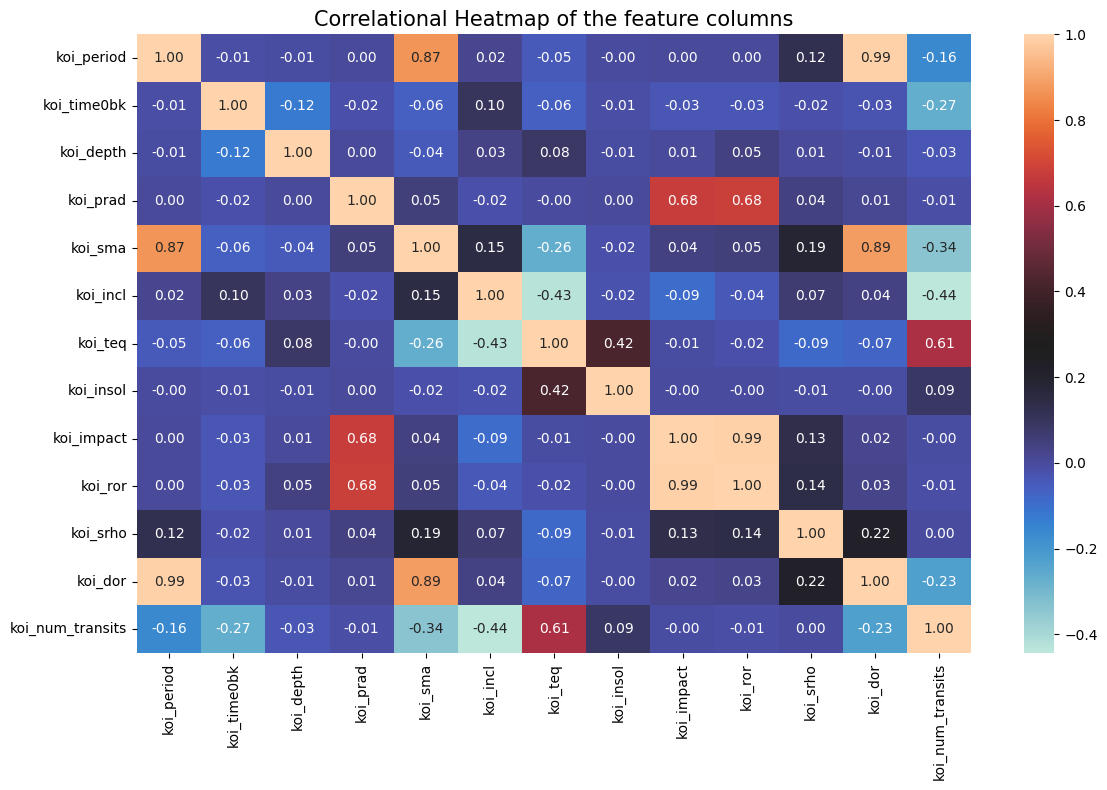

In [56]:
plt.figure(figsize=(12,8))
cor = df.iloc[:,1:].corr()
sns.heatmap(cor,cmap="icefire",fmt=".2f",annot=True)
plt.title("Correlational Heatmap of the feature columns", fontdict={"fontsize":15})
plt.tight_layout()
plt.show()

This heatmap clearly shows **high multicollinearity**, especially between `koi_ror` and `koi_impact` (0.99) and `koi_period` and `koi_sma` (0.87).

Plotting **Learning Curve**

In [ ]:
train_sizes, train_sc, val_sc = learning_curve(
  estimator,x_train,y_train,train_sizes=np.linspace(0.1,1.0,10),cv=5,n_jobs=-1,shuffle=True,random_state=59
)

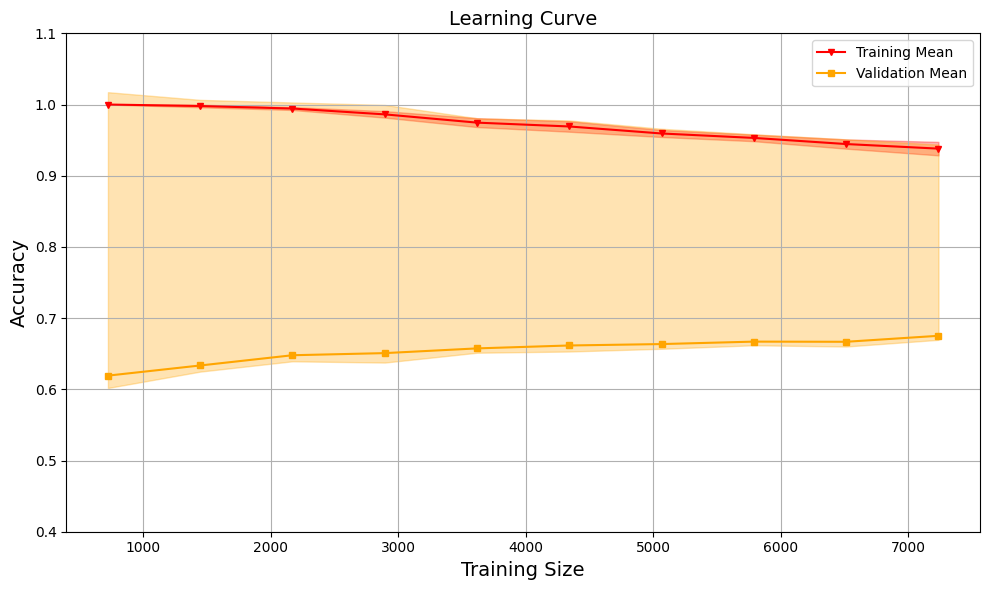

In [46]:
plt.figure(figsize=(10,6))

train_mean = np.mean(train_sc,axis=1)
train_std = np.std(train_sc,axis=1)
val_mean = np.mean(val_sc,axis=1)
val_std = np.std(val_sc,axis=1)

plt.plot(
  train_sizes,train_mean, color="red", marker="v", markersize=5, label="Training Mean"
)

plt.fill_between(
  train_sizes, train_mean-train_std, train_mean+train_std, color="red",alpha=0.3
)

plt.plot(
  train_sizes,val_mean, color="orange", marker="s", markersize=5, label="Validation Mean"
)

plt.fill_between(
  train_sizes, val_mean-val_std, train_mean+val_std, color="orange",alpha=0.3
)

plt.xlabel("Training Size", fontdict={"fontsize":14})
plt.ylabel("Accuracy",fontdict={"fontsize":14})
plt.title("Learning Curve", fontdict={"fontsize":14})
plt.ylim((0.4,1.1))
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

Well, the model is **overfitting** because it is **too complex** for the given problem and data. Adding more training data (by extending the x-axis) is unlikely to help significantly, as the validation accuracy has already flattened out.

I have tried everything I could to make it robust. But, I think this data is just too much complex for classification even with complex techniques and algorithms. 

## Summary

The biggest win of the entire fork is that I have initiated a 100 times more **standard** and **robust** way to find out the best possible performance. I have tested with Grid and Randomized searches for tuning the hyperparameters as much as possible, which is paired with ensemble techniques like **VotingClassifier** and **Stacking**. Furthermore, I tried using the multiple times Kaggle-winning algorithm, the **XGBoost** implementation of **Gradient Boosting**. 

However, the data was still too much complex for classification. If anyone has any idea, I would love to hear it!


Thanks for giving this notebook a look ! I hope you like it.